In [87]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold # import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam
from keras.optimizers import Adadelta
from keras.optimizers import Adagrad
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.models import Sequential
from keras import layers
from keras.layers import Flatten
from keras.layers import GRU
from keras.layers import Bidirectional
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from collections import Counter
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SVMSMOTE,SMOTE,SMOTENC,ADASYN
from keras.backend import clear_session
from keras.preprocessing.text import one_hot

clear_session()
# dataset
df=pd.read_csv('/Users/joe/Desktop/language-models-sprint1/data/train.csv')


#Split the data into train and test sets
X = df['text']
y = df['target']
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42,shuffle=True)


# apply tokonizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_tok = tokenizer.texts_to_sequences(X_train)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

X_test = tokenizer.texts_to_sequences(X_test)


# padding zerros to insure the sequence of words in a text is equal
# the tweet is 280 long, so I set the padding to 
padding_length=280
X_train_tok=pad_sequences(X_train_tok,padding='post',maxlen=padding_length)
X_test=pad_sequences(X_test,padding='post',maxlen=padding_length)


#early stopping 
early_stop=EarlyStopping(monitor='val_loss',patience=3, mode='min', verbose=1)


embedding_dim=20


#building model method
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=20, input_length=padding_length))
model.add(Bidirectional(GRU(30, return_sequences=True, activation='tanh')))
model.add(Bidirectional(GRU(85, return_sequences=True, activation='tanh')))
model.add(Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
optimizer=Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 280, 20)           355260    
_________________________________________________________________
bidirectional (Bidirectional (None, 280, 60)           9360      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 280, 170)          74970     
_________________________________________________________________
flatten (Flatten)            (None, 47600)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 47601     
Total params: 487,191
Trainable params: 487,191
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Main settings

history = model.fit(X_train_tok, y_train,
                    epochs=60
                    ,validation_split=0.09,
                    batch_size=800) #callbacks=[early_stop]


loss, accuracy = model.evaluate(X_train_tok, y_train, verbose=1)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Testing Accuracy:  {:.4f}".format(accuracy))



In [9]:
#for plotting

plt.style.use('ggplot')

def plot_accuracy_loss(model):
    training_accuracy = model.history['accuracy']
    validation_accuracy = model.history['val_accuracy']
    training_loss = model.history['loss']
    validation_loss = model.history['val_loss']
    x = range(1, len(training_accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, training_accuracy, 'g', label='Training accuracy')
    plt.plot(x, validation_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, training_loss, 'g', label='Training loss')
    plt.plot(x, validation_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

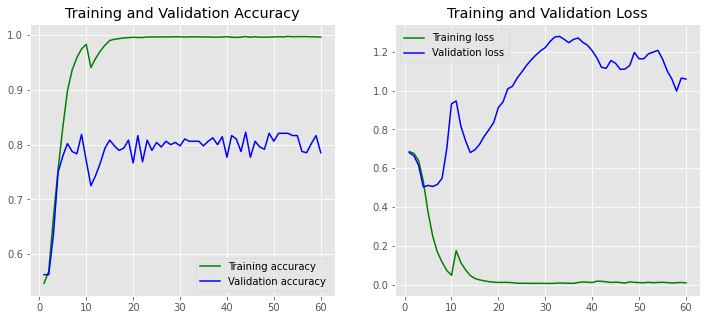

In [82]:
plot_accuracy_loss(history)